In [1]:
import numpy as np
import matplotlib.pyplot as pl
import time

In [2]:
from varname import nameof, argname
def copier(arg):
    og_name = argname('arg')
    new_name = og_name + '_copy'
    globals()[new_name] = arg

In [3]:
c = 3e8
G = 6.67e-11
pi = np.pi
const = 96/5*pi**(8/3)*(G/c**3)**(5/3)

Specific arguments

In [4]:
f0 = 120
Mc = 3e-4* 2e30
f_max = 200
T_obs = 1e4
beta = const*f0**(8/3)*Mc**(5/3)

f_signal = 40*f_max
nt = round(f_signal*T_obs)
t = np.arange(nt)/f_signal

f_ratio = 25
f_new = f_signal/f_ratio

In [5]:
beta

2.7439303219997145e-07

Generating signal and adding noise

In [6]:
phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
phi = np.mod(phi,2*pi)
signal = 1*np.exp(1j*phi)

nh = 50
noise = nh*np.random.normal(size = nt)
data = signal + noise

In [7]:
%reset_selective -f "^signal$"
%reset_selective -f noise
%reset_selective -f phi

In [8]:
# freqs = np.fft.fftshift(np.fft.fftfreq(len(t), d=t[1]-t[0]))
# fft = np.fft.fftshift(np.fft.fft(data))
# freqs = freqs[len(freqs)//2:]
# fft = fft[len(fft)//2:]

In [9]:
# pl.plot(freqs, np.abs(fft)/nt)
# pl.xlim(0, 200)

In [10]:
%load_ext cython

In [11]:
def numpy_strobo(beta, t, data, f_new):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    f_new = f_signal/f_ratio
    
    new_t *= f_new #changes the frequency to the new downsampled frequency (approximately, not exactly)
    floor_t = np.floor(new_t) #For some reason floor works better than round. Take it to the nearest time index which are integers
    idx = np.nonzero(np.diff(floor_t)) #The step that downsamples
    return idx

In [12]:
%%cython --a
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp
cimport numpy as np
import numpy as np
import cython
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)

cdef int nogil_round(double a) nogil:
    return int(a)

def cython_strobo(float beta,
                 double[:] t,
                 complex[:] data,
                 float f_new):
    assert t.shape[0] == data.shape[0]
    cdef Py_ssize_t i
    new_t = np.zeros((t.shape[0]), dtype = np.long)
    cdef long[:] new_t_view = new_t
    
    for i in prange(t.shape[0], nogil=True):
        new_t_view[i] = nogil_round(f_new*-3/5*(1-8/3*beta*t[i])**(5/8)/beta)
    idx = np.diff(new_t).nonzero()[0]
#     return new_t
    cdef int temp_len = np.shape(idx)[0]
    resampled = np.zeros(temp_len, dtype = complex)
    t_out = np.zeros(temp_len, dtype = np.double)
    cdef complex[:] resampled_view = resampled
    cdef double[:] t_out_view = t_out
    cdef long[:] idx_view = idx
    for i in prange(temp_len, nogil=True):
        resampled_view[i] = data[idx_view[i]]
        t_out_view[i] = (new_t_view[idx_view[i]]-new_t_view[0])/f_new
    return resampled, t_out

In [13]:
%%cython --force
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp
cimport numpy as np
import numpy as np
import cython
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)

cdef int nogil_round(double a) nogil:
    return int(a)

def cython_minimal(float beta,
                 double[:] t,
                 complex[:] data,
                 float f_new):
    assert t.shape[0] == data.shape[0]
    cdef Py_ssize_t i
    new_t = np.zeros((t.shape[0]), dtype = np.long)
    cdef long[:] new_t_view = new_t
    
    for i in prange(t.shape[0], nogil=True):
        new_t_view[i] = nogil_round(f_new*-3/5*(1-8/3*beta*t[i])**(5/8)/beta)
    return new_t

In file included from /home/neil/anaconda3/envs/PBHs/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /home/neil/anaconda3/envs/PBHs/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/neil/anaconda3/envs/PBHs/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/neil/.cache/ipython/cython/_cython_magic_aeb9fba42ebb5d9a21834fafbfcfb535.c:727:
/home/neil/anaconda3/envs/PBHs/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [14]:
def strobo_wrapper(beta, t, data, f_new):
    new_t = cython_minimal(beta, t, data, f_new)
    idx = np.nonzero(np.diff(new_t)) #The step that downsamples
    
    resampled = data[idx]
    t_out = (new_t[idx]-new_t[0])/f_new
    return resampled

In [19]:
def strobo(beta, t, data, f_new):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    
    new_t *= f_new #changes the frequency to the new downsampled frequency (approximately, not exactly)
    floor_t = np.floor(new_t) #For some reason floor works better than round. Take it to the nearest time index which are integers
    idx = np.nonzero(np.diff(floor_t)) #The step that downsamples
    resampled = data[idx]
    t_out = (new_t[idx]-new_t[0])/f_new
    return (resampled, t_out)

In [15]:
cython_strobo(beta, t, data, f_new)

/home/neil/anaconda3/envs/PBHs/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


(array([ -9.76054035-0.97314306j, -33.02475889+0.52533926j,
        -41.67759242+0.23020116j, ..., -59.98504329+0.25288032j,
         -7.40782173-0.85963585j,  72.83685024+0.97070214j]),
 array([0.00000000e+00, 3.12500005e-03, 6.25000009e-03, ...,
        1.00137559e+04, 1.00137598e+04, 1.00137627e+04]))

In [16]:
%timeit cython_strobo(beta, t, data, f_new)

/home/neil/anaconda3/envs/PBHs/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


1.03 s ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit strobo_wrapper(beta, t, data, f_new)

/home/neil/anaconda3/envs/PBHs/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


1.03 s ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit strobo(beta, t, data, f_new)

2.03 s ± 34.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
out, t_out = strobo(beta, t, data, f_new)
corrected = np.fft.fftshift(np.fft.fft(out))
freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
corrected = corrected[len(corrected)//2:]
freq_corrected = freq_corrected[len(freq_corrected)//2:]
nt_new = len(out)

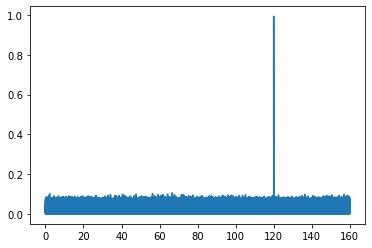

In [22]:
pl.plot(freq_corrected, np.abs(corrected/nt_new))

## Numerically estimating error

In [ ]:
def height_calc(beta):
    out, t_out = strobo_wrapper(beta, t, data, f_new)
    corrected = np.fft.fftshift(np.fft.fft(out))
    freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
    corrected = corrected[len(corrected)//2:]
    freq_corrected = freq_corrected[len(freq_corrected)//2:]
    nt_new = len(out)
    resampled_amplitudes = np.abs(corrected/nt_new)
    
    arg_max = np.argmax(resampled_amplitudes)
    peak_freq = freq_corrected[arg_max]
    peak_height = resampled_amplitudes[arg_max]
    return peak_freq, peak_height

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f strobo strobo(beta, data, f_ratio)

In [ ]:
%lprun -f height_calc height_calc(beta)

In [ ]:
tic = time.time()

offset_arr = np.logspace(-6, -3, 60)
ref_freq, ref_height = height_calc(beta)

offset_results = np.array([height_calc(beta+i*beta) for i in offset_arr])
toc = time.time()
print((toc-tic)/60)

In [ ]:
# pl.plot(offset_arr, offset_results[:,0]/ref_freq)
# pl.show()
pl.semilogx(offset_arr, offset_results[:,1]/ref_height)
pl.xlabel(r'$\Delta \beta / \beta$')
pl.ylabel('Height ratio')
pl.title(r'$\beta_{exact} = %.1E$' % beta)
pl.show()

In [ ]:
tic = time.time()
beta = 1e-7
offset_arr = np.logspace(-8, -3, 100)
ref_freq, ref_height = height_calc(beta)

offset_results = np.array([height_calc(beta+i*beta) for i in offset_arr])
toc = time.time()
print((toc-tic)/60)

In [ ]:
# pl.plot(offset_arr, offset_results[:,0]/ref_freq)
# pl.show()
pl.semilogx(offset_arr, offset_results[:,1]/ref_height)
pl.xlabel(r'$\Delta \beta / \beta$')
pl.ylabel('Height ratio')
pl.title(r'$\beta_{exact} = %.1E$' % beta)
pl.show()

In [ ]:
tic = time.time()
beta = 1e-3
offset_arr = np.logspace(-8, -3, 100)
ref_freq, ref_height = height_calc(beta)

offset_results = np.array([height_calc(beta+i*beta) for i in offset_arr])
toc = time.time()
print((toc-tic)/60)

In [ ]:
# pl.plot(offset_arr, offset_results[:,0]/ref_freq)
# pl.show()
pl.semilogx(offset_arr, offset_results[:,1]/ref_height)
pl.xlabel(r'$\Delta \beta / \beta$')
pl.ylabel('Height ratio')
pl.title(r'$\beta_{exact} = %.1E$' % beta)
pl.show()

In [ ]:
10/360*2*np.pi

## Delta Beta

In [ ]:
beta

In [ ]:
dPhi_thresh = 1
alpha = (1-8/3*beta*T_obs)
temp0 = dPhi_thresh/(2*pi*f0)
temp1 = alpha**(-5/8)
temp2 = (beta**(-1)+5/3*T_obs*alpha**(-1))**(-1)
dBeta_frac = temp0*temp1*temp2

In [ ]:
dBeta_frac

## Verifying TE

In [ ]:
dBeta_arr = beta*np.linspace(0, 0.01, 100)
analytic = (1-8/3*(beta+dBeta_arr)*T_obs)**(5/8)/(beta+dBeta_arr)
TE = alpha**(5/8)/beta - dBeta_arr/beta*alpha**(5/8)*(beta**(-1)+5/3*T_obs*alpha**(-1))

In [ ]:
pl.plot(dBeta_arr, analytic, label = 'analytic')
pl.plot(dBeta_arr, TE, label = "Taylor Expansion")
pl.xlabel("dBeta")

## Parameter space

In [ ]:
def beta_calc(f, M):
    M_temp = M*2e30
    return const*f**(8/3)*M_temp**(5/3)

In [ ]:
fspace = np.linspace(20, 2000, 1000)
Mspace = np.logspace(-5, -3, 1000)

[fgrid, Mgrid] = np.meshgrid(fspace, Mspace)
betaGrid = beta_calc(fgrid, Mgrid)

In [ ]:
pl.contourf(fspace, np.log10(Mspace), np.log10(betaGrid))
pl.colorbar()
pl.title(r'$log(\beta)$')
pl.xlabel("Frequency (Hz)")
pl.ylabel(r'$M_c$ ($M_\odot$)')

In [ ]:
def t_max_calc(f0, M, f_max):
    temp0 = (M/1e-2)**(-5/3)
    temp1 = (f0/200)**(-8/3) - (f_max/200)**(-8/3)
    return 1e3*temp0*temp1

def t_max_calc1(f0, beta, f_max):
    temp0 = 0.37/beta
    temp1 = 1-(f0/f_max)**(8/3)
    return temp0*temp1

In [ ]:
tMax_grid = t_max_calc(fgrid, Mgrid, 2000)
tMax_grid[tMax_grid>3e7] = 3e7

In [ ]:
pl.contourf(fspace, np.log10(Mspace), np.log10(tMax_grid))
pl.colorbar()
pl.title("t_max")
pl.xlabel("Frequency (Hz)")
pl.ylabel(r'$M_c$ ($M_\odot$)')

In [ ]:
tMax_grid1 = t_max_calc1(fgrid, betaGrid, 2000)
tMax_grid1[tMax_grid1>3e7] = 3e7

In [ ]:
pl.contourf(fspace, np.log10(Mspace), np.log10(tMax_grid1))
pl.colorbar()
pl.title("t_max")
pl.xlabel("Frequency (Hz)")
pl.ylabel(r'$M_c$ ($M_\odot$)')

In [ ]:
beta_space = np.logspace(-12, -1, 1000)
beta_small = 1e-7
beta_big = 1e-6
t_space = np.linspace(0, 1e4, int(1e3))
t_new_big = (1-8/3*beta_big*t_space)**(5/8)/beta_big
t_new_small = (1-8/3*beta_small*t_space)**(5/8)/beta_small